Visualizing the Healthscores across California Counties

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapefile
import plotly 
import plotly.plotly as py


In [2]:
#checking for the right versions of the packages
print(gpd.__version__ , shapely.__version__, plotly.__version__)

0.3.0 1.6.3 2.7.0


In [4]:
#importing the data
d = pd.read_csv('hpi.csv')

In [5]:
#looking at the data
d.head()

,geoid,pop2010,pct2010gq,city,zip,county_fips,county_name,urbantype,hpi2score,hpi2_pctile_pos,...,leb_pctile,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct,version
0,14000US06001400100,2937,0.1,Oakland,94704.0,6001,Alameda,urban_area,1.182028,99.114590,...,96.663673,71.605789,4.824259,15.713301,4.031702,3.824948,0.0,0.0,0,Wed13Dec17
1,14000US06001400200,1974,3.5,Oakland,94618.0,6001,Alameda,urban_area,1.325874,99.704863,...,96.612344,83.884970,0.000000,7.921867,8.193163,0.000000,0.0,0.0,0,Wed13Dec17
2,14000US06001400300,4865,0.8,Oakland,94618.0,6001,Alameda,urban_area,0.925666,95.932247,...,95.136661,67.384106,10.596026,8.671358,8.257450,5.091060,0.0,0.0,0,Wed13Dec17
3,14000US06001400400,3703,0.9,Oakland,94609.0,6001,Alameda,urban_area,1.117603,98.537149,...,68.959322,66.031054,12.203759,7.354944,9.043857,5.366385,0.0,0.0,0,Wed13Dec17
4,14000US06001400500,3517,3.6,Oakland,94609.0,6001,Alameda,urban_area,0.562799,83.318363,...,38.855383,51.180196,26.856649,5.987334,9.786989,6.188831,0.0,0.0,0,Wed13Dec17


In [6]:
#this d.info was run to look at the data
#d.info()

To get rid of the version, percentiles, and otehr columns which aren't needed in PCA

In [7]:
pcnt = [label for label in list(d) if "pcti" in label]
pcnt[:5]

['hpi2_pctile_pos',
 'hpi2_pctile_neg',
 'economic_pctile',
 'education_pctile',
 'houseing_pctile']

In [8]:
#drop from the dataframe
to_drop = ["geoid","version", "quintiles", "quartiles", "hpi_top25pct"] + pcnt 
df = d.drop(to_drop, axis = 1)

Looking at the info data below, we can see there are 8057 different entires, but only 7793 non-null entries in most columns. The city column has the LEAST non-null objects at 6972. 

The number of rows where any of the values are Nan. Since we dropped all the values with Nan.

create a dataframe with only notnull values

In [9]:
print("The number of rows with NaNs in them are: %d" % len(df[df.isnull().any(axis = 1)]))
df = df[df.notnull().all(axis = 1)]

The number of rows with NaNs in them are: 1242


In [10]:
len(df)

6815

In [11]:
len(df.groupby("county_name"))

54

In [12]:
#processing the categorical data by the county and take the "mode"
categorical = df.groupby(["county_name"]).agg(lambda x: x.value_counts().index[0])[["city", "urbantype"]].reset_index()
categorical.head()

,county_name,city,urbantype
0,Alameda,Oakland,urban_area
1,Amador,Pine Grove,rural
2,Butte,Chico,urban_area
3,Calaveras,Avery,rural
4,Colusa,College City,urban_cluster


The number of counties after cleaning

In [13]:
len(categorical)

54

In [14]:
group = df.groupby("county_name").mean().reset_index()
group["urbantype"] = categorical["urbantype"]
group["biggest city"] = categorical["city"]

In [15]:
group.head()

,county_name,pop2010,pct2010gq,zip,county_fips,hpi2score,economic,education,housing,healthcareaccess,...,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct,urbantype,biggest city
0,Alameda,4196.623529,1.879706,94588.085294,6001.0,0.341045,0.396776,0.293851,0.153843,0.553262,...,35.234458,13.723530,25.001636,22.179543,3.574085,0.000000,0.286748,0.0,urban_area,Oakland
1,Amador,4906.500000,2.300000,95652.500000,6005.0,0.150982,-0.347074,0.381420,0.151026,0.737064,...,86.096379,0.000000,0.000000,10.879978,3.023642,0.000000,0.000000,0.0,rural,Pine Grove
2,Butte,4262.212121,2.496970,95951.333333,6007.0,-0.175309,-0.640709,-0.186557,0.212270,0.198127,...,79.071955,0.950791,3.537372,12.415550,3.243284,0.781048,0.000000,0.0,urban_area,Chico
3,Calaveras,3375.000000,0.366667,95222.666667,6009.0,-0.053647,-0.229292,-0.885324,0.387684,0.392219,...,91.629281,0.000000,0.000000,8.370719,0.000000,0.000000,0.000000,0.0,rural,Avery
4,Colusa,5183.000000,0.000000,95912.000000,6011.0,-0.091837,-0.232988,-0.434281,0.368422,-0.635444,...,37.311634,0.000000,0.000000,62.688366,0.000000,0.000000,0.000000,0.0,urban_cluster,College City


The code below is used to calculate the correlation between variables

In [16]:
corr = df.corr()
corr.head()

,pop2010,pct2010gq,zip,county_fips,hpi2score,economic,education,housing,healthcareaccess,neighborhood,...,h20contam,leb,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct
pop2010,1.000000,-0.024989,0.076358,0.106648,-0.022811,-0.003717,-0.083637,0.049737,-0.004300,-0.058104,...,0.061688,-0.011571,-0.106977,-0.010764,0.034885,0.074218,0.221328,0.013089,0.054865,0.071273
pct2010gq,-0.024989,1.000000,0.034928,0.014807,-0.075776,-0.143775,0.004363,-0.108365,0.017437,0.058237,...,-0.053759,-0.108021,0.027731,0.051001,-0.005454,-0.046910,0.043279,0.011767,-0.013597,0.056818
zip,0.076358,0.034928,1.000000,0.276312,0.202374,0.107918,0.025094,0.291597,0.326976,0.270995,...,-0.276441,-0.092273,0.280706,-0.095534,0.098261,-0.331268,0.379323,0.090653,0.067788,0.003145
county_fips,0.106648,0.014807,0.276312,1.000000,0.063009,0.050620,-0.034159,0.121079,0.099378,0.080661,...,0.046785,-0.028519,0.167483,-0.201274,-0.043774,-0.071025,0.065210,-0.012503,-0.013348,0.015386
hpi2score,-0.022811,-0.075776,0.202374,0.063009,1.000000,0.951434,0.767557,0.710175,0.804472,0.356768,...,-0.299141,0.561417,0.639976,-0.281724,0.275268,-0.719144,0.392291,-0.044604,-0.038971,0.001132


In [17]:
corr["hpi2score"][:10]

pop2010            -0.022811
pct2010gq          -0.075776
zip                 0.202374
county_fips         0.063009
hpi2score           1.000000
economic            0.951434
education           0.767557
housing             0.710175
healthcareaccess    0.804472
neighborhood        0.356768
Name: hpi2score, dtype: float64

In [18]:
cities = list(df["city"].unique())
counties = list(df["county_name"].unique())

In [19]:
len(cities), len(counties)

(717, 54)

In [20]:
scores2 = []
cities2 = []
for city in cities:
    small_df = df[df["city"] == city]
    #if len(small_df) >1:
    scores2.append(np.average(small_df["hpi2score"]))
    cities2.append(city)
    

# PCA analysis:
check to see if there are any natuarlly occuring clusters

In [21]:
#in order to use PCA, we will get rid of the city, zip and county_fips (since these make it so the model doesn't generalize well)
#and get rid of hpiscore since this is what we want to predict
pc_df = df.drop(["city", "zip", "county_fips", "urbantype", "county_name", "hpi2score"], axis = 1)
pc_df.head()

,pop2010,pct2010gq,economic,education,housing,healthcareaccess,neighborhood,pollution,transportation,social,...,h20contam,leb,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct
0,2937,0.1,1.735963,0.948968,0.730552,1.285242,0.832170,0.878125,0.616855,1.336602,...,70.599583,86.985506,71.605789,4.824259,15.713301,4.031702,3.824948,0.0,0.0,0
1,1974,3.5,1.808761,1.137725,0.959728,1.004971,0.503232,0.657261,1.494366,1.227116,...,70.599583,86.957616,83.884970,0.000000,7.921867,8.193163,0.000000,0.0,0.0,0
2,4865,0.8,1.014492,1.348314,0.603628,1.268756,-0.291977,0.657261,0.822268,1.078500,...,70.599583,86.462942,67.384106,10.596026,8.671358,8.257450,5.091060,0.0,0.0,0
3,3703,0.9,1.277657,0.939501,0.356477,1.301729,0.070027,0.657261,1.756657,1.295417,...,70.599583,82.710897,66.031054,12.203759,7.354944,9.043857,5.366385,0.0,0.0,0
4,3517,3.6,0.577803,0.486145,0.029926,0.485643,-0.106063,0.657261,0.873072,0.949500,...,70.599583,80.123238,51.180196,26.856649,5.987334,9.786989,6.188831,0.0,0.0,0


In [51]:
#this gets the standard deviation of all the columns used in PCA
std_dev = pc_df.describe().iloc[2]

In [58]:
#as shown below, this data is now standardized
pca_df = pc_df/std_dev
pca_df.head()

,pop2010,pct2010gq,economic,education,housing,healthcareaccess,neighborhood,pollution,transportation,social,...,h20contam,leb,white_pct,black_pct,asian_pct,latino_pct,multiple_pct,nativeam_pct,pacificisl_pct,other_pct
0,1.624242,0.027867,1.995312,1.381847,1.107080,1.259262,2.192521,1.423239,1.627287,1.611436,...,0.289087,24.915953,2.616873,0.468579,1.004130,0.147647,1.976627,0.0,0.0,0.0
1,1.091677,0.975329,2.078986,1.656706,1.454376,0.984656,1.325866,1.065269,3.942191,1.479438,...,0.289087,24.907964,3.065622,0.000000,0.506232,0.300045,0.000000,0.0,0.0,0.0
2,2.690480,0.222932,1.166054,1.963357,0.914740,1.243109,-0.769273,1.065269,2.169171,1.300263,...,0.289087,24.766270,2.462589,1.029189,0.554127,0.302400,2.630918,0.0,0.0,0.0
3,2.047862,0.250799,1.468536,1.368061,0.540207,1.275415,0.184500,1.065269,4.634123,1.561783,...,0.289087,23.691542,2.413141,1.185348,0.470004,0.331199,2.773199,0.0,0.0,0.0
4,1.944998,1.003195,0.664126,0.707903,0.045349,0.475826,-0.279445,1.065269,2.303194,1.144738,...,0.289087,22.950338,1.870408,2.608579,0.382610,0.358414,3.198216,0.0,0.0,0.0


In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components =2)
pca.fit(pca_df)
pca.components_[0]

array([-1.00730385e-03,  2.01314971e-02, -2.47199898e-01, -1.87750991e-01,
       -2.27189711e-01, -2.42056302e-01, -9.28678442e-02, -1.31753228e-01,
       -1.23004281e-01, -2.30110928e-01, -2.42056302e-01, -2.14839304e-01,
       -1.75828685e-01, -1.44758449e-01,  5.53970723e-02, -1.12331947e-01,
       -4.59916680e-02, -2.24377009e-01, -1.50801450e-01, -2.57532758e-01,
       -2.37492217e-01,  1.66693764e-02, -3.89567747e-02, -1.14287823e-01,
       -1.46588119e-01, -2.25468525e-01,  1.30927764e-01,  1.48922239e-01,
       -6.79427974e-02, -1.56344295e-01,  8.09308878e-02,  7.94673153e-02,
        9.93045636e-02,  7.60794837e-02,  8.18285101e-02, -1.38197306e-01,
       -2.04233148e-01,  8.01349825e-02, -6.69618743e-02,  2.21823214e-01,
       -1.30155350e-01,  1.14345273e-03,  9.93334450e-03, -4.87276223e-05])

In [62]:
pca.explained_variance_ratio_
#only about 40% of the total variance is taken into account, which is relatively low

array([0.29612963, 0.10591079])

Text(0.5, 1.0, 'PCA analysis of different factors related to Hpi2Score')

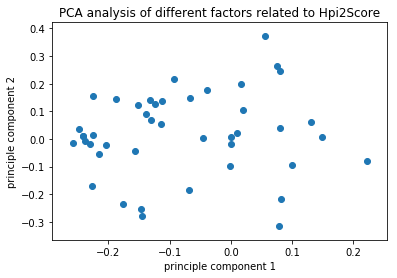

In [67]:
plt.scatter(pca.components_[0], pca.components_[1])
plt.xlabel("principle component 1")
plt.ylabel("principle component 2")
plt.title("PCA analysis of different factors related to Hpi2Score")

Overall, due to the low variance explained and the lack of defined clusters, it's hard to come to a conclusion from using PCA. Thus, we did not delve deeper into the topic.

# Choropleth map:
plotting the hpiscore relative to the geolocation to see if certain areas tended to have a higher hpi2score. Could also be used to determine visually if the counties closer to the water are generally "more healthy" like we suspect.

In [24]:
# number of counties to plot that we have data for.
len(df.groupby("county_name"))

54

Looking at the range of values for the HpiScore, some are actually negative, so have to take that into account

In [27]:
#the range of the hpi2score to plot
min(group["hpi2score"]),max(group["hpi2score"])

(-0.6454781168461541, 0.7790843871276596)

Since the hpiscore values were negative, it might make sense to normalize them by adding 1 (so they're all positive) and multiplying by 10 to get a number from 1 to 20. (example calculation shown below). 

We ended up not using the normalized scores though as the standardization was hard to interpret and also the choropleth map was able to plot and distinguish between negatives and decimal numbers quite well.

In [28]:
val = .779
(val+1)*10

17.79

In [29]:
colors_to_plot = []
for county in group["county_name"]:
    score = group[group["county_name"] == county]["hpi2score"]
    normalized_score = int((score)*10)
    colors_to_plot.append(normalized_score)
    #group["nom_scores"].loc[county] = score
    

In [30]:
group["norm_score"] = colors_to_plot

# BOKEH plotting

In [31]:
import bokeh

In [32]:
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.us_states import data as states
from bokeh.sampledata.unemployment import data as unemployment

In [33]:
#get the lat and long of the state of CA (since just a heatmap of Cali)
state_lon = states["CA"]["lons"]
state_lat = states["CA"]["lats"]


In [34]:
#make 3 lists, each with the name, lat and lon of all counties in California
name = []
lat = []
lons = []
names = [(name.append(counties[code]["detailed name"]), lat.append(counties[code]["lats"]), lons.append(counties[code]["lons"])) for code in counties if counties[code]["state"] in ["ca"]]


In [35]:
#put these lists into a dataframe for easier access
locations = pd.DataFrame()
locations["names"] = name
locations["lats"] = lat
locations["lons"] = lons

In [36]:
#example output of new df
locations.head()

,names,lats,lons
0,"Alameda County, California","[37.90194, 37.89909, 37.8965, 37.8941, 37.8870...","[-122.26254, -122.25876, -122.25586, -122.2530..."
1,"Alpine County, California","[38.88801, 38.88374, 38.87596, 38.86882, 38.85...","[-119.83828, -119.832, -119.82106, -119.81054,..."
2,"Amador County, California","[38.53596, 38.50946, 38.50418, 38.51042, 38.51...","[-120.70401, -120.64529, -120.59707, -120.5583..."
3,"Butte County, California","[39.52657, 39.52658, 39.51325, 39.46875, 39.45...","[-121.23727, -121.23866, -121.3052, -121.33296..."
4,"Calaveras County, California","[38.40885, 38.40873, 38.39886, 38.37713, 38.35...","[-120.0819, -120.08198, -120.12248, -120.16929..."


In [37]:
#get rid of "County, California" in each of the "names" so can join wtih hpi score column/df 
locations["county_names"] = locations["names"].apply(lambda x: x[:-19])

In [38]:
#new df check
locations.head(2)

,names,lats,lons,county_names
0,"Alameda County, California","[37.90194, 37.89909, 37.8965, 37.8941, 37.8870...","[-122.26254, -122.25876, -122.25586, -122.2530...",Alameda
1,"Alpine County, California","[38.88801, 38.88374, 38.87596, 38.86882, 38.85...","[-119.83828, -119.832, -119.82106, -119.81054,...",Alpine


In [39]:
#making a new df called scores_df which has the county name, and the hpiscore, (normalized and unnormalized).
scores_df = pd.DataFrame()
scores_df["county_names"] = group["county_name"]
scores_df["hpiscore"] = group["hpi2score"]
scores_df["norm_score"]= group["norm_score"]


In [40]:
scores_df.head(1)

,county_names,hpiscore,norm_score
0,Alameda,0.341045,3


In [71]:
#merging the scores and the geolocation data into one dataframe to make the choropleth from
full_df = pd.merge(scores_df, locations, how = "outer", on=["county_names"])
full_df.head(1)


,county_names,hpiscore,norm_score,names,lats,lons
0,Alameda,0.341045,3.0,"Alameda County, California","[37.90194, 37.89909, 37.8965, 37.8941, 37.8870...","[-122.26254, -122.25876, -122.25586, -122.2530..."


In [72]:
#these are the 8 counties that had NAN values for the hpiscore
full_df[full_df["hpiscore"].isnull()]

,county_names,hpiscore,norm_score,names,lats,lons
54,Alpine,NaN,NaN,"Alpine County, California","[38.88801, 38.88374, 38.87596, 38.86882, 38.85...","[-119.83828, -119.832, -119.82106, -119.81054,..."
55,Mariposa,NaN,NaN,"Mariposa County, California","[37.81174, 37.82308, 37.81132, 37.76436, 37.77...","[-120.08962, -120.06473, -120.02501, -119.9264..."
56,Sierra,NaN,NaN,"Sierra County, California","[39.50064, 39.48709, 39.47251, 39.46758, 39.46...","[-120.00222, -120.0025, -120.00284, -120.00289..."
57,Trinity,NaN,NaN,"Trinity County, California","[40.92684, 40.93048, 40.94971, 40.93436, 40.91...","[-123.62228, -123.58496, -123.5626, -123.52856..."


#### IMPORTANT NOTE: 
When we replaced the N/A before grouping the counties together in the data cleaning step, we ended up losing data on some counties. This is because these counties lacked other attributes which we used in the model. 

In [42]:
#replace the counties with no scores with 0.
full_df = full_df.fillna("0")

In [43]:
#http://bokeh.pydata.org/en/latest/docs/gallery/texas.html
#used the documentation above as a template to make my figure
from bokeh.io import output_notebook #plot in jupyter
from bokeh.models import LogColorMapper
#palette is a list of hexs
from bokeh.palettes import RdBu8 as palette
from bokeh.plotting import figure, show

In [45]:
palette.reverse()
#this makes the dark blue correlate with a higher health score and white with lower score

maps=dict(
    #issue with lat and long JSON encoding (need to turn into arrays)
    #https://github.com/bokeh/bokeh/issues/6222
    x=[np.asarray(i) for i in full_df["lons"]],
    y=[np.asarray(i) for i in full_df["lats"]],
    name=np.array(full_df["county_names"]),
    scores= np.array(full_df["hpiscore"]),
)

#colors
color_mapper = LogColorMapper(palette=palette)

p = figure(
    title="Hpi2score by California county", 
    #gets rid of axis on right/left (doesn't matter much for this graph)
    x_axis_location=None, 
    y_axis_location=None,
    
    #https://bokeh.pydata.org/en/latest/docs/user_guide/tools.html
    #all the different tools that can be added 
    tools="reset,hover,pan,box_zoom",
    #a key for the tools
    tooltips=[
        #naming the tools
        ("County name", "@name"), ("Hpi Scores", "@scores"), ("(Longitude, Latitude)", "($x, $y)")
    ])
p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=maps,
          fill_color={'field': 'scores', 'transform': color_mapper},
          fill_alpha=1, line_color="white", line_width=1)

output_notebook()
show(p)

Loading BokehJS ...

# Plotting Diversity:
see the relationship between diversity and the hpi2score

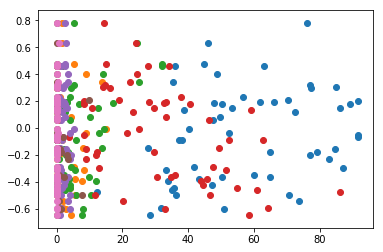

In [47]:
#all together making scatter plots:
plt.scatter(group["white_pct"], group["hpi2score"])
plt.scatter(group["black_pct"], group["hpi2score"])
plt.scatter(group["asian_pct"], group["hpi2score"])
plt.scatter(group["latino_pct"], group["hpi2score"])
plt.scatter(group["multiple_pct"], group["hpi2score"])
plt.scatter(group["nativeam_pct"], group["hpi2score"])
plt.scatter(group["pacificisl_pct"], group["hpi2score"])


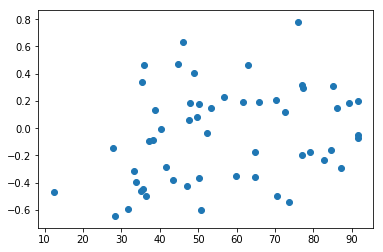

In [73]:
plt.scatter(group["white_pct"], group["hpi2score"])

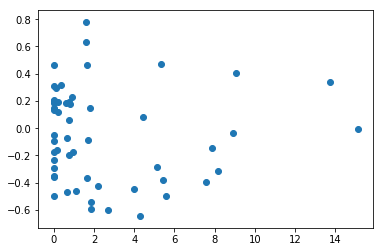

In [75]:
plt.scatter(group["black_pct"], group["hpi2score"])

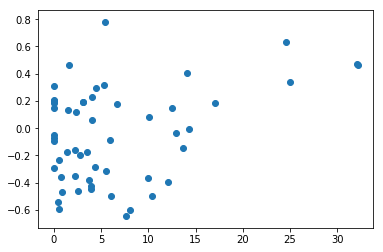

In [76]:
plt.scatter(group["asian_pct"], group["hpi2score"])


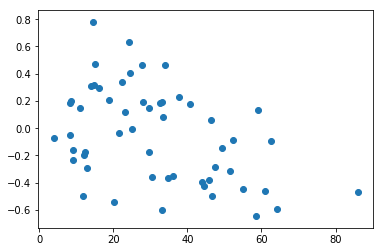

In [77]:
plt.scatter(group["latino_pct"], group["hpi2score"])


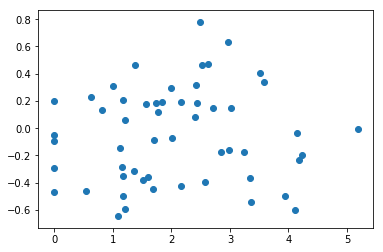

In [78]:
plt.scatter(group["multiple_pct"], group["hpi2score"])


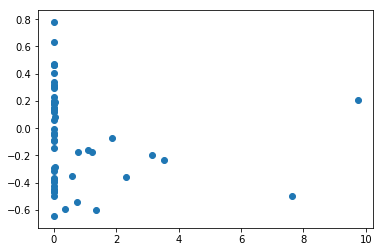

In [79]:
plt.scatter(group["nativeam_pct"], group["hpi2score"])


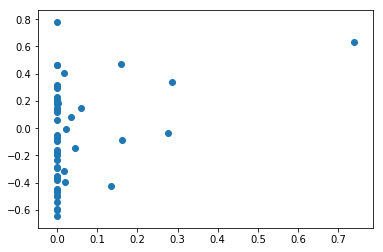

In [80]:
plt.scatter(group["pacificisl_pct"], group["hpi2score"])


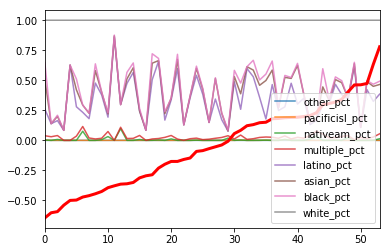

In [81]:
g1 = group.sort_values("hpi2score") #sort in order of increaseing hpi2scores left to right
list(g1)[-11:-3].reverse()
div = group[list(g1)[-11:-3][::-1]]
diversity = div.apply(lambda x: x/100.0)

fig = diversity.plot(stacked=True, alpha = 0.8,) # fill = True)
fig = plt.plot(np.arange(54), g1["hpi2score"], color = 'r', alpha = 1, linewidth = 3)
#fig = plt.plot()
#plt.plot?


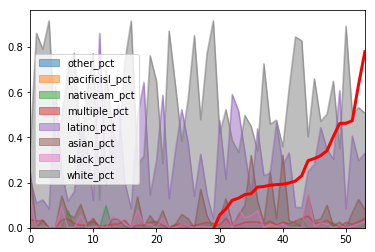

In [82]:
diversity = div.apply(lambda x: x/100.0)
diversity.plot.area(stacked = False)
fig = plt.plot(np.arange(54), g1["hpi2score"], color = 'r', alpha = 1, linewidth = 3)


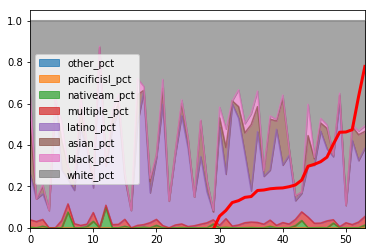

In [84]:
diversity.plot.area(alpha = 0.7)
fig = plt.plot(np.arange(54), g1["hpi2score"], color = 'r', alpha = 1, linewidth = 3)